LGBM Algo and it's results

LightGBM Test RMSE: 41991.16
LightGBM Test MAE: 3013.14
LightGBM Test R-squared: 0.8932
shape: (7, 2)
┌─────────────────────────────────┬────────────┐
│ Feature                         ┆ Importance │
│ ---                             ┆ ---        │
│ str                             ┆ i32        │
╞═════════════════════════════════╪════════════╡
│ Non Medicaid Amount Reimbursed… ┆ 2638       │
│ Medicaid Amount Reimburse (Sca… ┆ 2346       │
│ Number of Prescriptions (Scale… ┆ 2315       │
│ GDP per state (Scaled)          ┆ 2036       │
│ Temp Index (Scaled)             ┆ 1944       │
│ poverty index (Scaled)          ┆ 1867       │
│ personal income (Scaled)        ┆ 1854       │
└─────────────────────────────────┴────────────┘


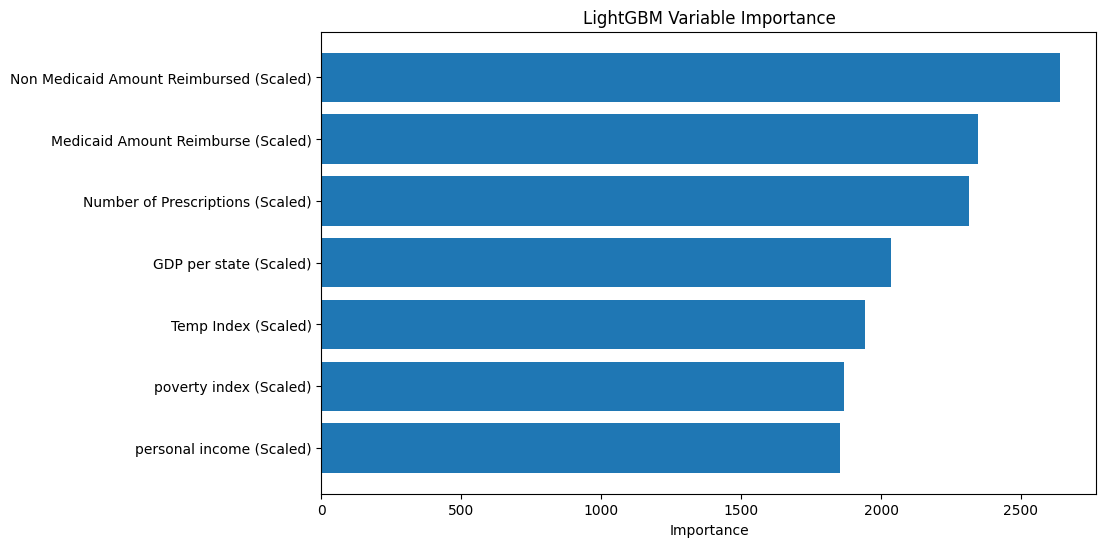

In [1]:

import polars as pl
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



# Read CSV using Polars
whole_data12 = pl.read_csv('/Users/prabhushankar/Desktop/whole_dataset.csv')

# -----------------------------------------
# 2. Split Data (80-20) using Polars
# -----------------------------------------

# Shuffle the dataset
whole_data12 = whole_data12.sample(n=whole_data12.height, shuffle=True, seed=123)


# Split index
split_idx = int(0.8 * whole_data12.height)

# Train-test split
train_data123 = whole_data12[:split_idx]
test_data123 = whole_data12[split_idx:]

# -----------------------------------------
# 3. Prepare Data for Modeling
# -----------------------------------------

# Define predictors and target
predictors = [
    'personal income (Scaled)',
    'GDP per state (Scaled)',
    'poverty index (Scaled)',
    'Temp Index (Scaled)',
    'Non Medicaid Amount Reimbursed (Scaled)',
    'Medicaid Amount Reimburse (Scaled)',
    'Number of Prescriptions (Scaled)'
]
target = 'Units Reimbursed'

# Extract features (X) and target (y)
X_train = train_data123.select(predictors).to_numpy()
y_train = train_data123.select(target).to_numpy().ravel()

X_test = test_data123.select(predictors).to_numpy()
y_test = test_data123.select(target).to_numpy().ravel()

# -----------------------------------------
# 4. Train LightGBM Model
# -----------------------------------------

train_dataset = lgb.Dataset(X_train, label=y_train)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': 123,
    'verbose': -1
}

# Train the model
model = lgb.train(
    params,
    train_dataset,
    num_boost_round=500
)

# -----------------------------------------
# 5. Make Predictions on Test Set
# -----------------------------------------

predictions_lgb = model.predict(X_test)

mse_value = mean_squared_error(y_test, predictions_lgb)
rmse_value = np.sqrt(mse_value)
print(f"LightGBM Test RMSE: {rmse_value:.2f}")

# MAE
mae_value = mean_absolute_error(y_test, predictions_lgb)
print(f"LightGBM Test MAE: {mae_value:.2f}")

# R-squared
r_squared_value = r2_score(y_test, predictions_lgb)
print(f"LightGBM Test R-squared: {r_squared_value:.4f}")
# -----------------------------------------
# 7. View Variable Importance
# -----------------------------------------

# Get feature importance
importance = model.feature_importance()
feature_importance_df = pl.DataFrame({
    'Feature': predictors,
    'Importance': importance
}).sort('Importance', descending=True)

print(feature_importance_df)

# Plot Variable Importance
plt.figure(figsize=(10,6))
plt.barh(feature_importance_df['Feature'].to_list(), feature_importance_df['Importance'].to_list())
plt.xlabel('Importance')
plt.title('LightGBM Variable Importance')
plt.gca().invert_yaxis()
plt.show()


In [3]:
# -----------------------------------------
# 8. Attach Predictions to Test Data
# -----------------------------------------

# 1. Create a Polars Series for predicted values
predicted_series = pl.Series(name="Predicted Units Reimbursed", values=predictions_lgb)

# 2. Add prediction column to test dataset
test_data_with_predictions = test_data123.with_columns(
    predicted_series
)

# -----------------------------------------
# 9. Recalculate RMSE and R-squared from test_data_with_predictions
# -----------------------------------------

# 3. Add Prediction Error and Squared Error columns
test_data_with_predictions = test_data_with_predictions.with_columns([
    (pl.col('Units Reimbursed') - pl.col('Predicted Units Reimbursed')).alias('Prediction Error'),
    ((pl.col('Units Reimbursed') - pl.col('Predicted Units Reimbursed')) ** 2).alias('Squared Error')
])

# 4. Calculate MSE (mean squared error)
mse_from_table = test_data_with_predictions.select(
    pl.col('Squared Error').mean()
).item()

# 5. RMSE = sqrt(MSE)
rmse_from_table = np.sqrt(mse_from_table)
print(f"Recalculated RMSE from table: {rmse_from_table:.2f}")

# 6. Calculate Total Sum of Squares (TSS)
mean_actual = test_data_with_predictions.select(
    pl.col('Units Reimbursed').mean()
).item()

tss = test_data_with_predictions.with_columns(
    ((pl.col('Units Reimbursed') - mean_actual) ** 2).alias('TSS Component')
).select(
    pl.col('TSS Component').sum()
).item()

# 7. Residual Sum of Squares (RSS)
rss = test_data_with_predictions.select(
    pl.col('Squared Error').sum()
).item()

# 8. R-squared calculation
r_squared_from_table = 1 - (rss / tss)
print(f"Recalculated R-squared from table: {r_squared_from_table:.4f}")


Recalculated RMSE from table: 41991.16
Recalculated R-squared from table: 0.8932


XGboost algo and it's results

XGBoost Test RMSE: 32894.65
XGBoost Test MAE: 1292.06
XGBoost Test R-squared: 0.9345
shape: (7, 2)
┌─────────────────────────────────┬────────────┐
│ Feature                         ┆ Importance │
│ ---                             ┆ ---        │
│ str                             ┆ f64        │
╞═════════════════════════════════╪════════════╡
│ Number of Prescriptions (Scale… ┆ 8232.0     │
│ personal income (Scaled)        ┆ 2695.0     │
│ Medicaid Amount Reimburse (Sca… ┆ 2277.0     │
│ Non Medicaid Amount Reimbursed… ┆ 1617.0     │
│ GDP per state (Scaled)          ┆ 1393.0     │
│ poverty index (Scaled)          ┆ 1244.0     │
│ Temp Index (Scaled)             ┆ 966.0      │
└─────────────────────────────────┴────────────┘


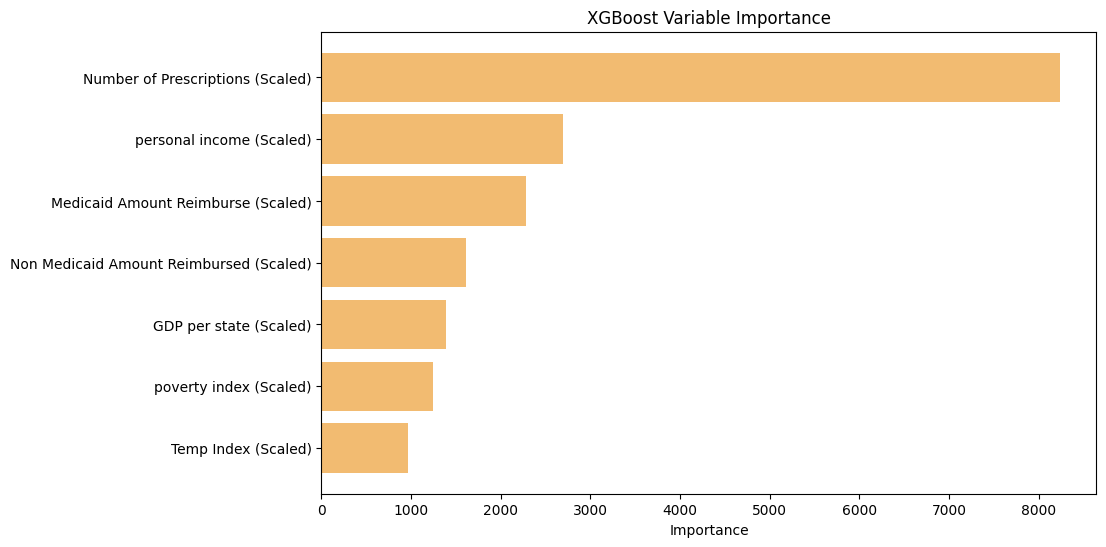

In [6]:
## -----------------------------------------
# 0. Import Required Libraries
# -----------------------------------------
import polars as pl
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------------------
# 1. Load Data
# -----------------------------------------
whole_data12 = pl.read_csv('/Users/prabhushankar/Desktop/whole_dataset.csv')

# -----------------------------------------
# 2. Split Data (80-20)
# -----------------------------------------

# Shuffle the dataset
whole_data12 = whole_data12.sample(n=whole_data12.height, shuffle=True, seed=123)

# Split index
split_idx = int(0.8 * whole_data12.height)

# Train-test split
train_data123 = whole_data12[:split_idx]
test_data123 = whole_data12[split_idx:]

# -----------------------------------------
# 3. Prepare Data for Modeling
# -----------------------------------------

# Define predictors and target
predictors = [
    'personal income (Scaled)',
    'GDP per state (Scaled)',
    'poverty index (Scaled)',
    'Temp Index (Scaled)',
    'Non Medicaid Amount Reimbursed (Scaled)',
    'Medicaid Amount Reimburse (Scaled)',
    'Number of Prescriptions (Scaled)'
]
target = 'Units Reimbursed'

# Extract features (X) and target (y)
X_train = train_data123.select(predictors).to_numpy()
y_train = train_data123.select(target).to_numpy().ravel()

X_test = test_data123.select(predictors).to_numpy()
y_test = test_data123.select(target).to_numpy().ravel()

# -----------------------------------------
# 4. Train XGBoost Model
# -----------------------------------------

# Convert data to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# Define parameters
params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.05,
    'max_depth': 6,
    'seed': 123,
    'verbosity': 0
}

# Train the model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500
)

# -----------------------------------------
# 5. Make Predictions on Test Set
# -----------------------------------------

predictions_xgb = model.predict(dtest)

# -----------------------------------------
# 6. Evaluate Model Performance
# -----------------------------------------

# RMSE
mse_value = mean_squared_error(y_test, predictions_xgb)
rmse_value = np.sqrt(mse_value)
print(f"XGBoost Test RMSE: {rmse_value:.2f}")

# MAE
mae_value = mean_absolute_error(y_test, predictions_xgb)
print(f"XGBoost Test MAE: {mae_value:.2f}")

# R-squared
r_squared_value = r2_score(y_test, predictions_xgb)
print(f"XGBoost Test R-squared: {r_squared_value:.4f}")

# -----------------------------------------
# 7. View Variable Importance
# -----------------------------------------

# Get feature importance
importance_dict = model.get_score(importance_type='weight')
# Note: importance_dict keys are feature indices like 'f0', 'f1', ...

# Map feature names manually
importance_ordered = []
for i, feature in enumerate(predictors):
    key = f'f{i}'
    importance_ordered.append(importance_dict.get(key, 0))

# Create Polars DataFrame
feature_importance_df = pl.DataFrame({
    'Feature': predictors,
    'Importance': importance_ordered
}).sort('Importance', descending=True)

print(feature_importance_df)

# Plot Variable Importance


plt.figure(figsize=(10,6))
plt.barh(
    feature_importance_df['Feature'].to_list(), 
    feature_importance_df['Importance'].to_list(), 
    color='#F2BB71'  # Set bar color here
)
plt.xlabel('Importance')
plt.title('XGBoost Variable Importance')
plt.gca().invert_yaxis()
plt.show()



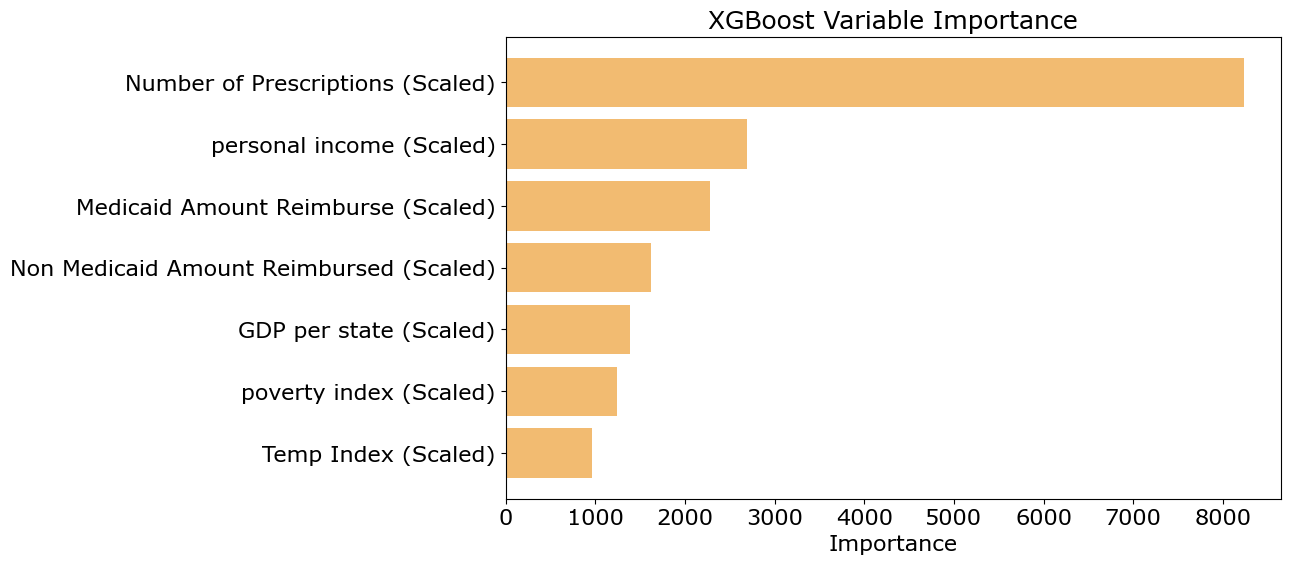

In [13]:
plt.figure(figsize=(10,6))
plt.barh(
    feature_importance_df['Feature'].to_list(), 
    feature_importance_df['Importance'].to_list(), 
    color='#F2BB71'
)
plt.xlabel('Importance', fontdict={'fontsize': 16, 'fontname': 'Verdana'})
plt.title('XGBoost Variable Importance', fontdict={'fontsize': 18, 'fontname': 'Verdana'})
plt.yticks(fontsize=16, fontname='Verdana')  # Y-axis labels
plt.xticks(fontsize=16, fontname='Verdana')  # X-axis labels
plt.gca().invert_yaxis()
plt.show()

In [18]:
feature_importance_df

Feature,Importance
str,f64
"""Number of Prescriptions (Scale…",8232.0
"""personal income (Scaled)""",2695.0
"""Medicaid Amount Reimburse (Sca…",2277.0
"""Non Medicaid Amount Reimbursed…",1617.0
"""GDP per state (Scaled)""",1393.0
"""poverty index (Scaled)""",1244.0
"""Temp Index (Scaled)""",966.0


In [5]:
# -----------------------------------------
# 9. Recalculate RMSE and R-squared using the full joined Test Dataset
# -----------------------------------------

# 1. Calculate Prediction Error and Squared Error
test_data_with_predictions = test_data_with_predictions.with_columns([
    (pl.col('Units Reimbursed') - pl.col('Predicted Units Reimbursed')).alias('Prediction Error'),
    ((pl.col('Units Reimbursed') - pl.col('Predicted Units Reimbursed')) ** 2).alias('Squared Error')
])

# 2. Calculate MSE
mse_from_table = test_data_with_predictions.select(
    pl.col('Squared Error').mean()
).item()

# 3. RMSE = sqrt(MSE)
rmse_from_table = np.sqrt(mse_from_table)
print(f"RMSE calculated from joined test dataset: {rmse_from_table:.2f}")

# -----------------------------------------
# 10. Calculate R-squared
# -----------------------------------------

# Step 1: Calculate Total Sum of Squares (TSS)
mean_actual = test_data_with_predictions.select(
    pl.col('Units Reimbursed').mean()
).item()

tss = test_data_with_predictions.with_columns(
    ((pl.col('Units Reimbursed') - mean_actual) ** 2).alias('TSS Component')
).select(
    pl.col('TSS Component').sum()
).item()

# Step 2: Residual Sum of Squares (RSS)
rss = test_data_with_predictions.select(
    pl.col('Squared Error').sum()
).item()

# Step 3: R-squared formula
r_squared_from_table = 1 - (rss / tss)
print(f"R-squared calculated from joined test dataset: {r_squared_from_table:.4f}")


RMSE calculated from joined test dataset: 41991.16
R-squared calculated from joined test dataset: 0.8932


In [ ]:
# 1. Create new data sample (must match the predictors order exactly!)
new_data_point = np.array([[0.55, 0.48, 0.33, 0.62, 0.50, 0.45, 0.58]])

# 2. Convert it to DMatrix (XGBoost needs DMatrix input)
dnew = xgb.DMatrix(new_data_point)

# 3. Predict
prediction_manual = model.predict(dnew)

print(f"Predicted Units Reimbursed: {prediction_manual[0]:.2f}")
